## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from itertools import chain
import torch
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer,AutoModelForTokenClassification,TrainingArguments,Trainer,pipeline

a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0630 09:32:17.801000 17576 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

## **Set Device**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Dataset**

In [4]:
data = pd.read_parquet("hf://datasets/boltuix/conll2025-ner/conll2025_ner.parquet")
data.head()

,split,tokens,ner_tags
0,train,"[Big, Managers, on, Campus]","[O, O, O, O]"
1,train,"[In, recent, years, ,, advanced, education, fo...","[O, B-DATE, I-DATE, O, O, O, O, O, O, O, O, O,..."
2,train,"[With, this, trend, ,, suddenly, the, mature, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,train,"[In, order, to, attract, this, group, of, seas...","[O, O, O, O, O, O, O, O, O, O, O, O, B-MONEY, ..."
4,train,"[In, response, ,, each, year, over, 1000, matu...","[O, O, O, O, O, O, B-CARDINAL, O, O, O, O, O, ..."


## **Shape of the Data**

In [5]:
print(f'No.of rows: {data.shape[0]}')
print(f'No.of Columns: {data.shape[1]}')

No.of rows: 143709
No.of Columns: 3


## **Dimension of the Data**

In [6]:
print(f'Dimension of the Data: {data.ndim}')

Dimension of the Data: 2


## **Information about the Data**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143709 entries, 0 to 143708
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   split     143709 non-null  object
 1   tokens    143709 non-null  object
 2   ner_tags  143709 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


## **Columns List**

In [8]:
print(f'Columns in the Data: {data.columns.tolist()}')

Columns in the Data: ['split', 'tokens', 'ner_tags']


## **Number of Null Values**

In [9]:
null_val = pd.DataFrame(data.isnull().sum()).reset_index()
null_val.columns = ['columns', 'values']
null_val

,columns,values
0,split,0
1,tokens,0
2,ner_tags,0


## **Number of Unique values**

In [10]:
data["tokens"] = data["tokens"].apply(tuple)
data["ner_tags"] = data["ner_tags"].apply(tuple)

In [11]:
unique_values = data.nunique().reset_index()
unique_values.columns = ['columns', 'unique_values']
unique_values

,columns,unique_values
0,split,3
1,tokens,135548
2,ner_tags,48057


## **Description about the Data**

In [12]:
data.describe(include='all').transpose()

,count,unique,top,freq
split,143709,3,train,115812
tokens,143709,135548,"(yeah,)",751
ner_tags,143709,48057,"(O, O)",4365


## **Data Distribution**

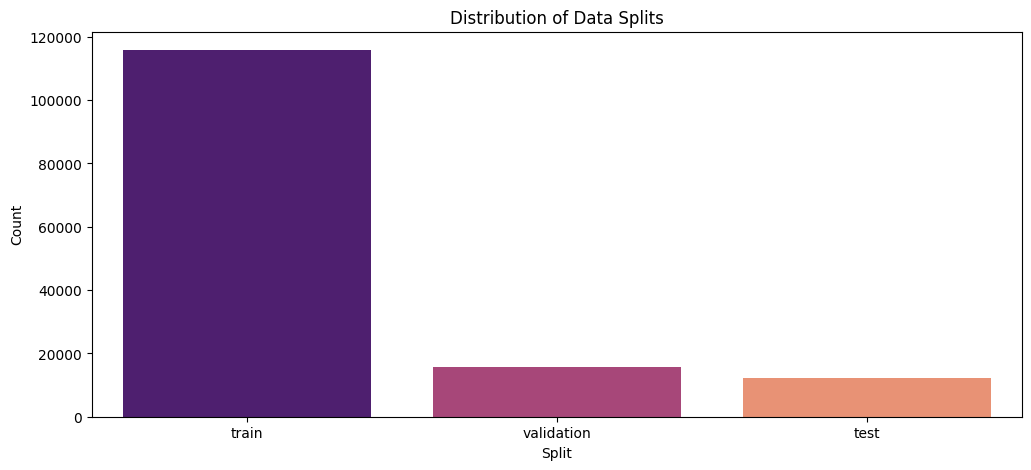

In [13]:
plt.figure(figsize=(12, 5))
sns.countplot(data=data, x ='split', order=data['split'].value_counts().index,hue ='split',palette="magma")
plt.title('Distribution of Data Splits')
plt.xlabel('Split')
plt.ylabel('Count')
plt.show()

## **Tag Distribution**

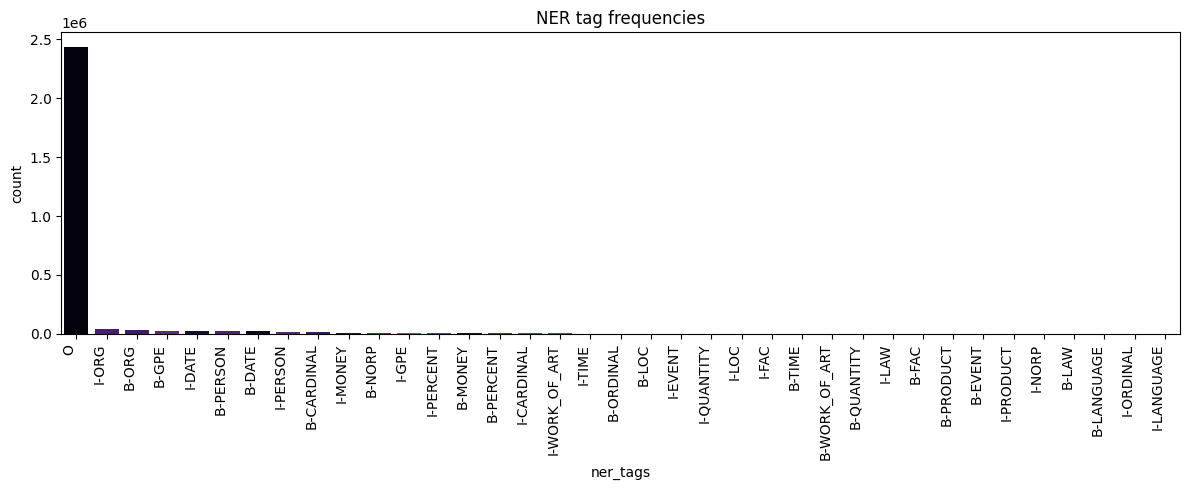

In [14]:
tags_long = data.explode('ner_tags')

plt.figure(figsize=(12, 5))
sns.countplot(data=tags_long,x='ner_tags',order=tags_long['ner_tags'].value_counts().index,hue = "ner_tags",palette="magma")
plt.xticks(rotation=90, ha='right')
plt.title('NER tag frequencies')
plt.tight_layout()
plt.show()

In [15]:
pro = tags_long["ner_tags"].value_counts().reset_index()
pro.head()

,ner_tags,count
0,O,2435208
1,I-ORG,40660
2,B-ORG,29963
3,B-GPE,28133
4,I-DATE,28088


## **Tag Distribution without O**

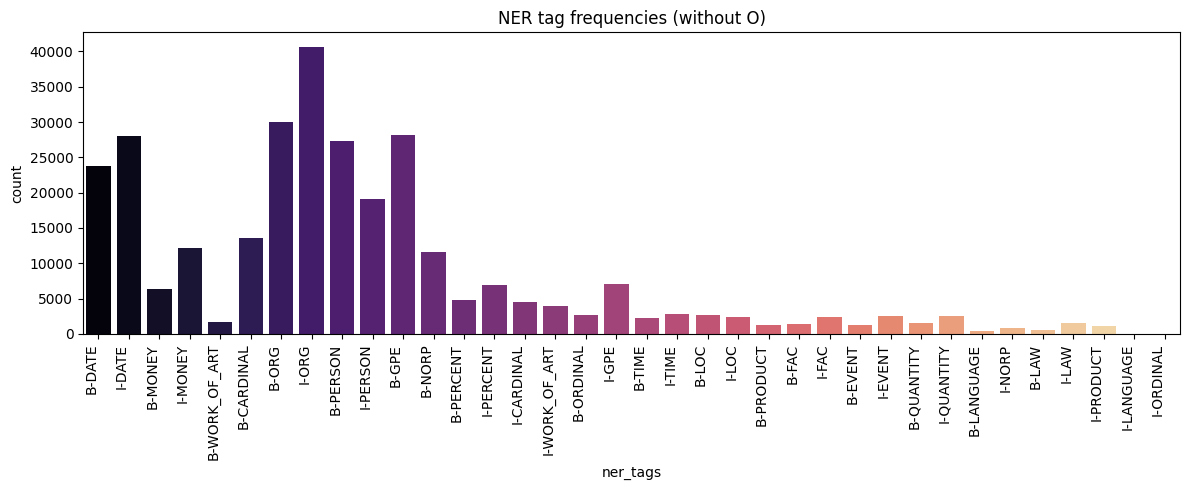

In [16]:
order = [tag for tag in tags_long['ner_tags'].unique() if tag != "O"]

plt.figure(figsize=(12, 5))
sns.countplot(data=tags_long[tags_long['ner_tags'] != "O"], x ='ner_tags', order = order, hue="ner_tags", palette="magma")
plt.xticks(rotation=90, ha='right')
plt.title('NER tag frequencies (without O)')
plt.tight_layout()
plt.show()

In [17]:
data['tokens'] = data['tokens'].apply(list)
data['ner_tags'] = data['ner_tags'].apply(list)

In [18]:
data.head()

,split,tokens,ner_tags
0,train,"[Big, Managers, on, Campus]","[O, O, O, O]"
1,train,"[In, recent, years, ,, advanced, education, fo...","[O, B-DATE, I-DATE, O, O, O, O, O, O, O, O, O,..."
2,train,"[With, this, trend, ,, suddenly, the, mature, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,train,"[In, order, to, attract, this, group, of, seas...","[O, O, O, O, O, O, O, O, O, O, O, O, B-MONEY, ..."
4,train,"[In, response, ,, each, year, over, 1000, matu...","[O, O, O, O, O, O, B-CARDINAL, O, O, O, O, O, ..."


In [19]:
unique_tags = sorted(set(tag for tags in data['ner_tags'] for tag in tags))
num_unique_tags = len(unique_tags)

print(f'Unique NER tags: {unique_tags}')
print(f'Number of unique NER tags: {num_unique_tags}')

Unique NER tags: ['B-CARDINAL', 'B-DATE', 'B-EVENT', 'B-FAC', 'B-GPE', 'B-LANGUAGE', 'B-LAW', 'B-LOC', 'B-MONEY', 'B-NORP', 'B-ORDINAL', 'B-ORG', 'B-PERCENT', 'B-PERSON', 'B-PRODUCT', 'B-QUANTITY', 'B-TIME', 'B-WORK_OF_ART', 'I-CARDINAL', 'I-DATE', 'I-EVENT', 'I-FAC', 'I-GPE', 'I-LANGUAGE', 'I-LAW', 'I-LOC', 'I-MONEY', 'I-NORP', 'I-ORDINAL', 'I-ORG', 'I-PERCENT', 'I-PERSON', 'I-PRODUCT', 'I-QUANTITY', 'I-TIME', 'I-WORK_OF_ART', 'O']
Number of unique NER tags: 37


In [20]:
tag2idx = {tag:idx for idx, tag in enumerate(unique_tags)}
idx2tag = {idx:tag for tag,idx in tag2idx.items()}

print(f'Tag to Index Mapping: {tag2idx}')
print(f'Index to Tag Mapping: {idx2tag}')

Tag to Index Mapping: {'B-CARDINAL': 0, 'B-DATE': 1, 'B-EVENT': 2, 'B-FAC': 3, 'B-GPE': 4, 'B-LANGUAGE': 5, 'B-LAW': 6, 'B-LOC': 7, 'B-MONEY': 8, 'B-NORP': 9, 'B-ORDINAL': 10, 'B-ORG': 11, 'B-PERCENT': 12, 'B-PERSON': 13, 'B-PRODUCT': 14, 'B-QUANTITY': 15, 'B-TIME': 16, 'B-WORK_OF_ART': 17, 'I-CARDINAL': 18, 'I-DATE': 19, 'I-EVENT': 20, 'I-FAC': 21, 'I-GPE': 22, 'I-LANGUAGE': 23, 'I-LAW': 24, 'I-LOC': 25, 'I-MONEY': 26, 'I-NORP': 27, 'I-ORDINAL': 28, 'I-ORG': 29, 'I-PERCENT': 30, 'I-PERSON': 31, 'I-PRODUCT': 32, 'I-QUANTITY': 33, 'I-TIME': 34, 'I-WORK_OF_ART': 35, 'O': 36}
Index to Tag Mapping: {0: 'B-CARDINAL', 1: 'B-DATE', 2: 'B-EVENT', 3: 'B-FAC', 4: 'B-GPE', 5: 'B-LANGUAGE', 6: 'B-LAW', 7: 'B-LOC', 8: 'B-MONEY', 9: 'B-NORP', 10: 'B-ORDINAL', 11: 'B-ORG', 12: 'B-PERCENT', 13: 'B-PERSON', 14: 'B-PRODUCT', 15: 'B-QUANTITY', 16: 'B-TIME', 17: 'B-WORK_OF_ART', 18: 'I-CARDINAL', 19: 'I-DATE', 20: 'I-EVENT', 21: 'I-FAC', 22: 'I-GPE', 23: 'I-LANGUAGE', 24: 'I-LAW', 25: 'I-LOC', 26: 'I-MONE

In [21]:
data['ner_tags'] = data['ner_tags'].apply(lambda tags: [tag2idx[tag] for tag in tags])


In [22]:
data.head()

,split,tokens,ner_tags
0,train,"[Big, Managers, on, Campus]","[36, 36, 36, 36]"
1,train,"[In, recent, years, ,, advanced, education, fo...","[36, 1, 19, 36, 36, 36, 36, 36, 36, 36, 36, 36..."
2,train,"[With, this, trend, ,, suddenly, the, mature, ...","[36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 3..."
3,train,"[In, order, to, attract, this, group, of, seas...","[36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 3..."
4,train,"[In, response, ,, each, year, over, 1000, matu...","[36, 36, 36, 36, 36, 36, 0, 36, 36, 36, 36, 36..."


## **Huggingface Dataset**

In [23]:
train_dataset = data[data["split"] == "train"]
val_dataset = data[data["split"] == "validation"]
test_dataset = data[data["split"] == "test"]

print(f'Train Dataset Shape: {train_dataset.shape}')
print(f'Validation Dataset Shape: {val_dataset.shape}')
print(f'Test Dataset Shape: {test_dataset.shape}')

Train Dataset Shape: (115812, 3)
Validation Dataset Shape: (15680, 3)
Test Dataset Shape: (12217, 3)


In [24]:
train_ds = Dataset.from_pandas(train_dataset)
val_ds = Dataset.from_pandas(val_dataset)
test_ds = Dataset.from_pandas(test_dataset)

In [25]:
train_ds = train_ds.remove_columns(["__index_level_0__"])
val_ds = val_ds.remove_columns(["__index_level_0__"])
test_ds = test_ds.remove_columns(["__index_level_0__"])

In [26]:
dataset = DatasetDict({
    'train': train_ds,
    'validation': val_ds,
    'test': test_ds
})

In [27]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['split', 'tokens', 'ner_tags'],
        num_rows: 115812
    })
    validation: Dataset({
        features: ['split', 'tokens', 'ner_tags'],
        num_rows: 15680
    })
    test: Dataset({
        features: ['split', 'tokens', 'ner_tags'],
        num_rows: 12217
    })
})


In [28]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(data):
    tokenized_inputs = tokenizer(data["tokens"], truncation=True, is_split_into_words=True,max_length=128, padding="max_length")

    labels = []
    word_ids = tokenized_inputs.word_ids()  # Word ID per sub-token

    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)  # Special tokens
        elif word_idx != previous_word_idx:
            labels.append(data["ner_tags"][word_idx])  # First token of word
        else:
            labels.append(-100)  # Subsequent tokens
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels)


a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 12217/12217 [00:04<00:00, 2554.73 examples/s]


In [29]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased",num_labels = num_unique_tags )

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
label_list = list(tag2idx.keys())

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_preds = [
        [label_list[p] for (p, l) in zip(pred_row, label_row) if l != -100]
        for pred_row, label_row in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred_row, label_row) if l != -100]
        for pred_row, label_row in zip(predictions, labels)
    ]

    flat_preds = list(chain.from_iterable(true_preds))
    flat_labels = list(chain.from_iterable(true_labels))

    report = classification_report(flat_labels, flat_preds, output_dict=True)

    # Print individual class performance
    print("\n📊 Per-Tag F1 Scores:")
    for label, score in report.items():
        if isinstance(score, dict):
            print(f"{label:15s} | F1: {score['f1-score']:.3f} | Precision: {score['precision']:.3f} | Recall: {score['recall']:.3f}")

    return {
        "f1": report["weighted avg"]["f1-score"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"]
    }

In [31]:
args = TrainingArguments(
    "ner-model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01
)

trainer = Trainer(
    model = model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
  2%|▏         | 500/21717 [02:55<2:09:23,  2.73it/s]

{'loss': 0.2922, 'grad_norm': 1.2708771228790283, 'learning_rate': 1.9539531242805175e-05, 'epoch': 0.07}


  5%|▍         | 1000/21717 [05:59<2:08:37,  2.68it/s]

{'loss': 0.1168, 'grad_norm': 1.5426337718963623, 'learning_rate': 1.9079062485610353e-05, 'epoch': 0.14}


  7%|▋         | 1500/21717 [09:07<2:05:17,  2.69it/s]

{'loss': 0.0987, 'grad_norm': 1.0094839334487915, 'learning_rate': 1.861859372841553e-05, 'epoch': 0.21}


  9%|▉         | 2000/21717 [12:15<2:03:27,  2.66it/s]

{'loss': 0.0859, 'grad_norm': 1.7380201816558838, 'learning_rate': 1.8158124971220704e-05, 'epoch': 0.28}


 12%|█▏        | 2500/21717 [15:24<2:01:03,  2.65it/s]

{'loss': 0.0862, 'grad_norm': 1.8449664115905762, 'learning_rate': 1.769765621402588e-05, 'epoch': 0.35}


 14%|█▍        | 3000/21717 [18:33<1:58:36,  2.63it/s]

{'loss': 0.0836, 'grad_norm': 1.1979964971542358, 'learning_rate': 1.7237187456831055e-05, 'epoch': 0.41}


 16%|█▌        | 3500/21717 [21:43<1:53:54,  2.67it/s]

{'loss': 0.0782, 'grad_norm': 1.10016930103302, 'learning_rate': 1.6776718699636232e-05, 'epoch': 0.48}


 18%|█▊        | 4000/21717 [24:52<1:48:57,  2.71it/s]

{'loss': 0.0749, 'grad_norm': 0.6122045516967773, 'learning_rate': 1.6316249942441406e-05, 'epoch': 0.55}


 21%|██        | 4500/21717 [27:58<1:45:38,  2.72it/s]

{'loss': 0.073, 'grad_norm': 1.1209737062454224, 'learning_rate': 1.5855781185246583e-05, 'epoch': 0.62}


 23%|██▎       | 5000/21717 [31:04<1:43:07,  2.70it/s]

{'loss': 0.075, 'grad_norm': 2.840219736099243, 'learning_rate': 1.539531242805176e-05, 'epoch': 0.69}


 25%|██▌       | 5500/21717 [34:10<1:39:33,  2.71it/s]

{'loss': 0.0694, 'grad_norm': 0.5680403709411621, 'learning_rate': 1.4934843670856934e-05, 'epoch': 0.76}


 28%|██▊       | 6000/21717 [37:17<1:36:05,  2.73it/s]

{'loss': 0.0699, 'grad_norm': 2.7394847869873047, 'learning_rate': 1.4474374913662108e-05, 'epoch': 0.83}


 30%|██▉       | 6500/21717 [40:23<1:33:02,  2.73it/s]

{'loss': 0.0731, 'grad_norm': 2.539569854736328, 'learning_rate': 1.4013906156467285e-05, 'epoch': 0.9}


 32%|███▏      | 7000/21717 [43:29<1:30:47,  2.70it/s]

{'loss': 0.0668, 'grad_norm': 0.9530563950538635, 'learning_rate': 1.355343739927246e-05, 'epoch': 0.97}


 33%|███▎      | 7239/21717 [44:58<1:12:29,  3.33it/s]a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


📊 Per-Tag F1 Scores:
B-CARDINAL      | F1: 0.841 | Precision: 0.804 | Recall: 0.882
B-DATE          | F1: 0.886 | Precision: 0.872 | Recall: 0.901
B-EVENT         | F1: 0.676 | Precision: 0.714 | Recall: 0.642
B-FAC           | F1: 0.606 | Precision: 0.589 | Recall: 0.624
B-GPE           | F1: 0.930 | Precision: 0.926 | Recall: 0.933
B-LANGUAGE      | F1: 0.806 | Precision: 0.926 | Recall: 0.714
B-LAW           | F1: 0.667 | Precision: 0.551 | Recall: 0.844
B-LOC           | F1: 0.764 | Precision: 0.811 | Recall: 0.722
B-MONEY         | F1: 0.913 | Precision: 0.905 | Recall: 0.922
B-NORP          | F1: 0.873 | Precision: 0.826 | Recall: 0.926
B-ORDINAL       | F1: 0.796 | Precision: 0.736 | Recall: 0.866
B-ORG           | F1: 0.902 | Precision: 0.889 | Recall: 0.914
B-PERCENT       | F1: 0.934 | Precision: 0.938 | Recall: 0.930
B-PERSON        | F1: 0.932 | Precision: 0.905 | Recall: 0.961
B-PRODUCT       | F1: 0.504 | Precision: 0.691 | Recall: 0.397
B-QUANTITY      | F1: 0.765 | Pre

 35%|███▍      | 7500/21717 [1:00:28<1:26:25,  2.74it/s]  

{'loss': 0.0547, 'grad_norm': 0.2554258704185486, 'learning_rate': 1.3092968642077638e-05, 'epoch': 1.04}


 37%|███▋      | 8000/21717 [1:03:31<1:23:21,  2.74it/s]

{'loss': 0.0483, 'grad_norm': 0.7221314907073975, 'learning_rate': 1.2632499884882811e-05, 'epoch': 1.11}


 39%|███▉      | 8500/21717 [1:06:36<1:20:54,  2.72it/s]

{'loss': 0.0499, 'grad_norm': 2.245847702026367, 'learning_rate': 1.2172031127687987e-05, 'epoch': 1.17}


 41%|████▏     | 9000/21717 [1:09:44<1:19:09,  2.68it/s]

{'loss': 0.0484, 'grad_norm': 1.3905396461486816, 'learning_rate': 1.1711562370493164e-05, 'epoch': 1.24}


 44%|████▎     | 9500/21717 [1:12:51<1:17:03,  2.64it/s]

{'loss': 0.0475, 'grad_norm': 1.5168927907943726, 'learning_rate': 1.1251093613298338e-05, 'epoch': 1.31}


 46%|████▌     | 10000/21717 [1:15:59<1:12:21,  2.70it/s]

{'loss': 0.0479, 'grad_norm': 1.1592071056365967, 'learning_rate': 1.0790624856103513e-05, 'epoch': 1.38}


 48%|████▊     | 10500/21717 [1:19:05<1:08:25,  2.73it/s]

{'loss': 0.0462, 'grad_norm': 1.7378140687942505, 'learning_rate': 1.033015609890869e-05, 'epoch': 1.45}


 51%|█████     | 11000/21717 [1:22:12<1:06:24,  2.69it/s]

{'loss': 0.0477, 'grad_norm': 0.13516467809677124, 'learning_rate': 9.869687341713864e-06, 'epoch': 1.52}


 53%|█████▎    | 11500/21717 [1:25:18<1:02:48,  2.71it/s]

{'loss': 0.043, 'grad_norm': 2.5371029376983643, 'learning_rate': 9.409218584519042e-06, 'epoch': 1.59}


 55%|█████▌    | 12000/21717 [1:28:24<59:56,  2.70it/s]  

{'loss': 0.0429, 'grad_norm': 0.903209924697876, 'learning_rate': 8.948749827324217e-06, 'epoch': 1.66}


 58%|█████▊    | 12500/21717 [1:31:31<56:42,  2.71it/s]  

{'loss': 0.0447, 'grad_norm': 0.7219765186309814, 'learning_rate': 8.488281070129393e-06, 'epoch': 1.73}


 60%|█████▉    | 13000/21717 [1:34:38<54:12,  2.68it/s]  

{'loss': 0.0419, 'grad_norm': 0.8067983984947205, 'learning_rate': 8.027812312934568e-06, 'epoch': 1.8}


 62%|██████▏   | 13500/21717 [1:37:45<50:47,  2.70it/s]  

{'loss': 0.0448, 'grad_norm': 0.10106739401817322, 'learning_rate': 7.567343555739744e-06, 'epoch': 1.86}


 64%|██████▍   | 14000/21717 [1:40:52<48:00,  2.68it/s]  

{'loss': 0.0436, 'grad_norm': 0.6198940873146057, 'learning_rate': 7.106874798544919e-06, 'epoch': 1.93}


 67%|██████▋   | 14478/21717 [1:43:51<37:00,  3.26it/s]  a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


📊 Per-Tag F1 Scores:
B-CARDINAL      | F1: 0.847 | Precision: 0.791 | Recall: 0.910
B-DATE          | F1: 0.892 | Precision: 0.883 | Recall: 0.902
B-EVENT         | F1: 0.684 | Precision: 0.809 | Recall: 0.592
B-FAC           | F1: 0.615 | Precision: 0.575 | Recall: 0.662
B-GPE           | F1: 0.936 | Precision: 0.933 | Recall: 0.940
B-LANGUAGE      | F1: 0.778 | Precision: 0.757 | Recall: 0.800
B-LAW           | F1: 0.716 | Precision: 0.686 | Recall: 0.750
B-LOC           | F1: 0.789 | Precision: 0.784 | Recall: 0.794
B-MONEY         | F1: 0.910 | Precision: 0.903 | Recall: 0.916
B-NORP          | F1: 0.895 | Precision: 0.883 | Recall: 0.908
B-ORDINAL       | F1: 0.809 | Precision: 0.755 | Recall: 0.872
B-ORG           | F1: 0.906 | Precision: 0.897 | Recall: 0.916
B-PERCENT       | F1: 0.920 | Precision: 0.923 | Recall: 0.916
B-PERSON        | F1: 0.939 | Precision: 0.917 | Recall: 0.962
B-PRODUCT       | F1: 0.569 | Precision: 0.696 | Recall: 0.481
B-QUANTITY      | F1: 0.781 | Pre

 67%|██████▋   | 14500/21717 [1:45:59<46:14,  2.60it/s]   

{'loss': 0.0425, 'grad_norm': 0.8138832449913025, 'learning_rate': 6.6464060413500955e-06, 'epoch': 2.0}


 69%|██████▉   | 15000/21717 [1:49:06<41:17,  2.71it/s]  

{'loss': 0.0276, 'grad_norm': 0.9270005226135254, 'learning_rate': 6.18593728415527e-06, 'epoch': 2.07}


 71%|███████▏  | 15500/21717 [1:52:12<38:12,  2.71it/s]  

{'loss': 0.0292, 'grad_norm': 0.4174116551876068, 'learning_rate': 5.725468526960446e-06, 'epoch': 2.14}


 74%|███████▎  | 16000/21717 [1:55:18<35:07,  2.71it/s]  

{'loss': 0.0319, 'grad_norm': 1.2539585828781128, 'learning_rate': 5.264999769765622e-06, 'epoch': 2.21}


 76%|███████▌  | 16500/21717 [1:58:24<31:58,  2.72it/s]  

{'loss': 0.0274, 'grad_norm': 0.826798677444458, 'learning_rate': 4.8045310125707975e-06, 'epoch': 2.28}


 78%|███████▊  | 17000/21717 [2:01:31<28:46,  2.73it/s]  

{'loss': 0.0297, 'grad_norm': 0.06155474856495857, 'learning_rate': 4.344062255375973e-06, 'epoch': 2.35}


 81%|████████  | 17500/21717 [2:04:37<26:13,  2.68it/s]  

{'loss': 0.0291, 'grad_norm': 4.851905345916748, 'learning_rate': 3.8835934981811485e-06, 'epoch': 2.42}


 83%|████████▎ | 18000/21717 [2:07:44<23:04,  2.68it/s]

{'loss': 0.0267, 'grad_norm': 0.029800157994031906, 'learning_rate': 3.4231247409863244e-06, 'epoch': 2.49}


 85%|████████▌ | 18500/21717 [2:10:50<19:40,  2.72it/s]

{'loss': 0.0278, 'grad_norm': 0.6381577253341675, 'learning_rate': 2.9626559837915e-06, 'epoch': 2.56}


 87%|████████▋ | 19000/21717 [2:13:57<16:47,  2.70it/s]

{'loss': 0.0276, 'grad_norm': 0.35083767771720886, 'learning_rate': 2.502187226596676e-06, 'epoch': 2.62}


 90%|████████▉ | 19500/21717 [2:17:04<13:41,  2.70it/s]

{'loss': 0.0259, 'grad_norm': 0.06014588102698326, 'learning_rate': 2.0417184694018513e-06, 'epoch': 2.69}


 92%|█████████▏| 20000/21717 [2:20:11<10:34,  2.71it/s]

{'loss': 0.026, 'grad_norm': 0.47626519203186035, 'learning_rate': 1.581249712207027e-06, 'epoch': 2.76}


 94%|█████████▍| 20500/21717 [2:23:17<07:37,  2.66it/s]

{'loss': 0.0259, 'grad_norm': 0.5696680545806885, 'learning_rate': 1.1207809550122025e-06, 'epoch': 2.83}


 97%|█████████▋| 21000/21717 [2:26:24<04:25,  2.70it/s]

{'loss': 0.0267, 'grad_norm': 0.6110408902168274, 'learning_rate': 6.603121978173783e-07, 'epoch': 2.9}


 99%|█████████▉| 21500/21717 [2:29:32<01:20,  2.69it/s]

{'loss': 0.0289, 'grad_norm': 4.0623698234558105, 'learning_rate': 1.9984344062255376e-07, 'epoch': 2.97}


100%|██████████| 21717/21717 [2:30:54<00:00,  3.34it/s]a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 


📊 Per-Tag F1 Scores:
B-CARDINAL      | F1: 0.849 | Precision: 0.818 | Recall: 0.882
B-DATE          | F1: 0.892 | Precision: 0.887 | Recall: 0.897
B-EVENT         | F1: 0.647 | Precision: 0.759 | Recall: 0.564
B-FAC           | F1: 0.602 | Precision: 0.575 | Recall: 0.632
B-GPE           | F1: 0.937 | Precision: 0.935 | Recall: 0.938
B-LANGUAGE      | F1: 0.686 | Precision: 0.686 | Recall: 0.686
B-LAW           | F1: 0.763 | Precision: 0.746 | Recall: 0.781
B-LOC           | F1: 0.793 | Precision: 0.782 | Recall: 0.804
B-MONEY         | F1: 0.912 | Precision: 0.908 | Recall: 0.916
B-NORP          | F1: 0.901 | Precision: 0.892 | Recall: 0.910
B-ORDINAL       | F1: 0.780 | Precision: 0.763 | Recall: 0.797
B-ORG           | F1: 0.908 | Precision: 0.900 | Recall: 0.917
B-PERCENT       | F1: 0.920 | Precision: 0.929 | Recall: 0.912
B-PERSON        | F1: 0.942 | Precision: 0.929 | Recall: 0.956
B-PRODUCT       | F1: 0.570 | Precision: 0.655 | Recall: 0.505
B-QUANTITY      | F1: 0.780 | Pre

TrainOutput(global_step=21717, training_loss=0.0562051220504916, metrics={'train_runtime': 9173.4974, 'train_samples_per_second': 37.874, 'train_steps_per_second': 2.367, 'total_flos': 2.2703156745606144e+16, 'train_loss': 0.0562051220504916, 'epoch': 3.0})

## **Test Evaluation**

In [32]:
trainer.evaluate(tokenized_dataset["test"])

100%|█████████▉| 763/764 [01:27<00:00,  8.36it/s]a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
a:\Data Science\Huggingface + Pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn


📊 Per-Tag F1 Scores:
B-CARDINAL      | F1: 0.816 | Precision: 0.818 | Recall: 0.814
B-DATE          | F1: 0.864 | Precision: 0.841 | Recall: 0.889
B-EVENT         | F1: 0.635 | Precision: 0.635 | Recall: 0.635
B-FAC           | F1: 0.662 | Precision: 0.705 | Recall: 0.624
B-GPE           | F1: 0.927 | Precision: 0.931 | Recall: 0.922
B-LANGUAGE      | F1: 0.649 | Precision: 0.800 | Recall: 0.545
B-LAW           | F1: 0.624 | Precision: 0.592 | Recall: 0.659
B-LOC           | F1: 0.720 | Precision: 0.689 | Recall: 0.753
B-MONEY         | F1: 0.909 | Precision: 0.894 | Recall: 0.924
B-NORP          | F1: 0.920 | Precision: 0.907 | Recall: 0.933
B-ORDINAL       | F1: 0.758 | Precision: 0.719 | Recall: 0.802
B-ORG           | F1: 0.903 | Precision: 0.890 | Recall: 0.918
B-PERCENT       | F1: 0.916 | Precision: 0.898 | Recall: 0.934
B-PERSON        | F1: 0.924 | Precision: 0.921 | Recall: 0.927
B-PRODUCT       | F1: 0.685 | Precision: 0.670 | Recall: 0.700
B-QUANTITY      | F1: 0.759 | Pre

{'eval_loss': 0.0735793486237526,
 'eval_f1': 0.979961788287299,
 'eval_precision': 0.9802169930081773,
 'eval_recall': 0.9798393406708049,
 'eval_runtime': 91.5412,
 'eval_samples_per_second': 133.459,
 'eval_steps_per_second': 8.346,
 'epoch': 3.0}

## **Training vs Validation Loss**

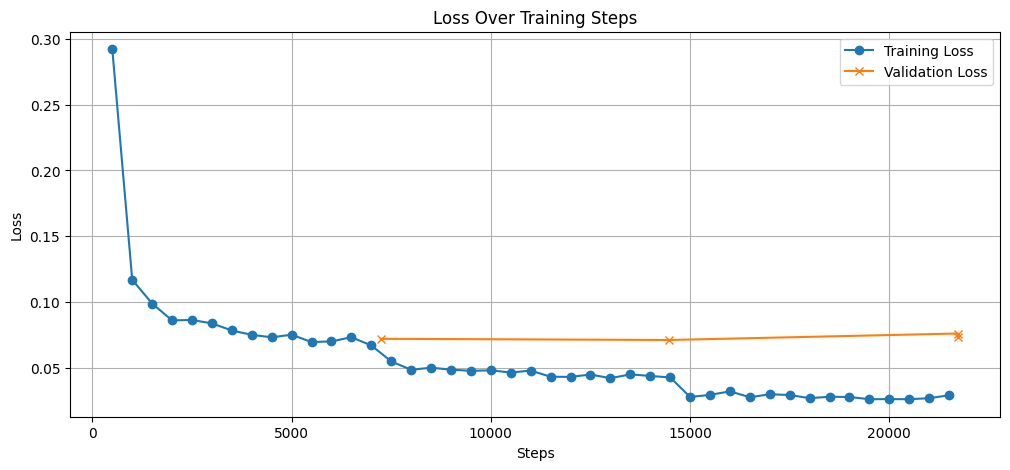

In [44]:
training_logs = trainer.state.log_history


train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
eval_steps = [log["step"] for log in training_logs if "eval_loss" in log]
train_steps = [log["step"] for log in training_logs if "loss" in log]

plt.figure(figsize=(12, 5))
plt.plot(train_steps, train_loss, label="Training Loss", marker='o')
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker='x')
plt.title("Loss Over Training Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## **Save Model**

In [34]:
trainer.save_model("ner_model_bert")
tokenizer.save_pretrained("ner_model_bert")

('ner_model_bert\\tokenizer_config.json',
 'ner_model_bert\\special_tokens_map.json',
 'ner_model_bert\\vocab.txt',
 'ner_model_bert\\added_tokens.json',
 'ner_model_bert\\tokenizer.json')

## **Inference**

In [43]:
model = AutoModelForTokenClassification.from_pretrained("ner_model_bert")
tokenizer = AutoTokenizer.from_pretrained("ner_model_bert")

model.config.id2label = idx2tag
model.config.label2id = {v: k for k, v in idx2tag.items()}

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

sentence = "Barack Obama was born in 23/11/1990 in Hawaii."

results = ner_pipeline(sentence)

for r in results:
    print(f"Word: {r['word']}, Entity: {r['entity_group']}, Score: {r['score']:.3f}")

Word: Barack Obama, Entity: PERSON, Score: 0.983
Word: 23 / 11 / 1990, Entity: DATE, Score: 0.994
Word: Hawaii, Entity: GPE, Score: 0.969
